In [2]:
from basic_utils import *

On cuda:0
Figure directory exists.


In [3]:
class CyDataset(Dataset):
    def __init__(self):

        self.D = []
        self.L = []
                
        with open('/datacommons/carlsonlab/srs108/old/ol/Delhi_clean.pkl', "rb") as fp:
            for station in tqdm(pkl.load(fp)):
                self.D.append(tuple((station['Image'][:,:,:3], station['PM25'])))
                
        with open('/datacommons/carlsonlab/srs108/old/ol/Lucknow.pkl', "rb") as fp:
            for station in tqdm(pkl.load(fp)):
#                 self.L.append(tuple((station['Image'][:,:,:3], station['PM25'])))
                for datapoint in station:
                    luck_img = datapoint['Image'][:,:,:3]
                    if luck_img.shape == (224, 224,3):  
                        self.L.append(tuple((luck_img, datapoint['PM'])))

        self.D = random.choices(self.D, k= len(self.L))
        
    def __len__(self): return (len(self.D))
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

            #Delhi normalization
        transform  = transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomVerticalFlip(),
                            transforms.Pad(16),
                            transforms.ToTensor(),
#                             transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

        d_img = self.D[idx][0]
        d_img = transform(d_img)        
        l_img = self.L[idx][0]
        l_img = transform(l_img)
        
        sample = {
              'D': d_img,
              'D pm' : torch.tensor(self.D[idx][1]),
              'L': l_img,
              'L pm' : torch.tensor(self.L[idx][1])
        }
        return sample

In [4]:
tr = CyDataset()
train, val = train_test_split(tr,test_size=0.2, random_state=69)
dataloader = DataLoader(
    train,
    batch_size=1, # 1
    shuffle=True)

val_dataloader = DataLoader(
    val,
    batch_size=1, # 1
    shuffle=True)

In [5]:
# class ImageDataset(Dataset):
#     def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
#         self.transform = transforms.Compose(transforms_)
#         self.unaligned = unaligned
#         self.mode = mode
#         if self.mode == 'train':
#             self.files_A = sorted(glob.glob(os.path.join(root+'/thil')+'/*.*'))
#             self.files_B = sorted(glob.glob(os.path.join(root+'/americanclub')+'/*.*'))
#         elif self.mode == 'test':
#             self.files_A = sorted(glob.glob(os.path.join(root+'/thil')+'/*.*'))
#             self.files_B = sorted(glob.glob(os.path.join(root+'/americanclub')+'/*.*'))

#     def  __getitem__(self, index):
#         image_A = Image.open(self.files_A[index % len(self.files_A)])
        
#         if self.unaligned:
#             image_B = Image.open(self.files_B[np.random.randint(0, len(self.files_B)-1)])
#         else:
#             image_B = Image.open(self.files_B[index % len(self.files_B)])
#         if image_A.mode != 'RGB':
#             image_A = to_rgb(image_A)
#         if image_B.mode != 'RGB':
#             image_B = to_rgb(image_B)
            
#         item_A = self.transform(image_A)
#         item_B = self.transform(image_B)
#         return {'A':item_A, 'B':item_B}
    
#     def __len__(self):
#         return max(len(self.files_A), len(self.files_B))

In [6]:
# root = '/datacommons/carlsonlab/srs108/planet_imgs/'

# dataloader = DataLoader(
#     ImageDataset(root, transforms_=transforms_, unaligned=True),
#     batch_size=1, # 1
#     shuffle=True,)

# val_dataloader = DataLoader(
#     ImageDataset(root, transforms_=transforms_, unaligned=True, mode='test'),
#     batch_size=1,
#     shuffle=True,
# )

In [7]:
criterion_GAN = nn.BCEWithLogitsLoss().to(device) #this is different from phase two, it was MSE...?
criterion_cycle = torch.nn.L1Loss().to(device)
criterion_identity = torch.nn.L1Loss().to(device)
criterion_PM = torch.nn.MSELoss().to(device)

In [8]:
input_shape = (channels, img_height, img_width) # (3,256,256)
n_residual_blocks = 6 # suggested default, number of residual blocks in generator


generator_checkpoint     = torch.load('/datacommons/carlsonlab/srs108/cycle/saved_models/best_G.pt')
discriminator_checkpoint = torch.load('/datacommons/carlsonlab/srs108/cycle/saved_models/best_D.pt')

G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_AB.load_state_dict(generator_checkpoint['G_AB'])
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
G_BA.load_state_dict(generator_checkpoint['G_BA'])

G_AB.to(device)
G_BA.to(device)

D_A = Discriminator(input_shape)
D_A.load_state_dict(discriminator_checkpoint['D_A'])
D_B = Discriminator(input_shape)
D_B.load_state_dict(discriminator_checkpoint['D_B'])

D_A.to(device)
D_B.to(device)

C_A = Multi_City_CNN()
C_A.load_state_dict(torch.load('/datacommons/carlsonlab/srs108/cycle/saved_models/dlm4.pt'))
C_A.to(device)

D_ft = FeatureDiscriminator()
D_ft.to(device)

C_B = Multi_City_CNN()
C_B.to(device)
print()

In [9]:
D_ft.apply(weights_init_normal)
C_B.apply(weights_init_normal)
print()

In [10]:
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1,b2)
)

optimizer_D = torch.optim.Adam(
    itertools.chain(D_A.parameters(), D_B.parameters()), lr=lr/2, betas=(b1,b2)
)

optimizer_C_A = torch.optim.Adam(
    C_A.parameters(), lr=1e-3, betas=(b1, b2)
)

optimizer_D_ft = torch.optim.Adam(
    D_ft.parameters(), lr = lr/10, betas = (0.5,0.9)
)

optimizer_C_B = torch.optim.Adam(
    C_B.parameters(), lr=lr/10, betas=(0.5, 0.999)
) 

In [11]:
def sample_images(city1, city2, dataloader, e, i, show = False, save=False):
    source = next(iter(dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = source['D'].type(Tensor)
    fake_B = G_AB(real_A).detach()
    real_B = source['L'].type(Tensor)
    fake_A = G_BA(real_B).detach()

    recon_A = G_BA(fake_B).detach()
    recon_B = G_AB(fake_A).detach()

    real_A = make_grid(real_A, nrow=5, normalize=True, scale_each=True, padding=1)
    fake_B = make_grid(fake_B, nrow=5, normalize=True, scale_each=True, padding=1)
    real_B = make_grid(real_B, nrow=5, normalize=True, scale_each=True, padding=1)
    fake_A = make_grid(fake_A, nrow=5, normalize=True, scale_each=True, padding=1)
    recon_A = make_grid(recon_A, nrow=5, normalize=True, scale_each=True, padding=1)
    recon_B = make_grid(recon_B, nrow=5, normalize=True, scale_each=True, padding=1)
    
    # Set individual titles
    titles = [f'Real {city1}', f'Fake {city1}', f'Recon {city1}', f'Real {city2}', f'Fake {city2}', f'Recon {city2}']
    
    plt.figure(figsize=(12, 9))
    plt.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.02, wspace=0.02, hspace=0.02)  # Adjust spacing

    for index, grid in enumerate([real_A, fake_B, recon_A, real_B, fake_A, recon_B]):
        plt.subplot(1, 6, index+1)
        plt.imshow(grid.cpu().permute(1, 2, 0))
        plt.title(titles[index])
        plt.axis('off')

    if save:
        plt.savefig(os.path.join('Figure_PDFs', f'epoch_{str(e+1)}_iter{str(i+1)}.png'), bbox_inches='tight', pad_inches=0, facecolor='white')
    
    if show:
        plt.show()
    plt.close();
    
    
def prediction(out, target):
    label = torch.where(out.data>torch.FloatTensor([0.5]).to(device),torch.ones(out.size()[0]).long().to(device), torch.zeros(out.size()[0]).long().to(device))
    acc = (label == target).sum().item() / target.size()[0];
    return label, acc


def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
        nets (network list)   -- a list of networks
        requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        if net is not None:
            for param in net.parameters():
                param.requires_grad = requires_grad
                ;
                

In [12]:

# D_ft = FeatureDiscriminator().to(device)    

In [13]:
# test = torch.rand(5,3,256,256).to(device)
# # label = torch.
# x = D_ft(C_B(test)).squeeze(1)

In [14]:
# x

In [15]:
# source_label = torch.ones(test.size()[0]).long().to(device)
# source_label

In [16]:
# x = torch.tensor([0.51,0.49,0.66, 0.33, 0.2]).to(device)

In [17]:
# print(x, source_label)

In [18]:
# real_A = torch.rand(5,3,256,256).to(device)
# test
# test = D_ft(C_B(r))


0.11002396047115326 tensor([73.2000], device='cuda:0')
0.09629470854997635 tensor([37.], device='cuda:0')
0.06848881393671036 tensor([42.1700], device='cuda:0')
0.10061147809028625 tensor([61.6100], device='cuda:0')
0.24330587685108185 tensor([111.8800], device='cuda:0')
0.22671455144882202 tensor([46.5500], device='cuda:0')
0.30619364976882935 tensor([44.2100], device='cuda:0')
0.26057329773902893 tensor([227.7200], device='cuda:0')
0.3197653889656067 tensor([69.4400], device='cuda:0')
0.3056631088256836 tensor([49.5800], device='cuda:0')
0.3703775405883789 tensor([98.2900], device='cuda:0')
0.4016417860984802 tensor([68.6700], device='cuda:0')
0.5681101083755493 tensor([101.8800], device='cuda:0')
0.44743844866752625 tensor([112.9100], device='cuda:0')
0.5614100098609924 tensor([140.9800], device='cuda:0')
0.6258563995361328 tensor([95.1500], device='cuda:0')
0.6013336181640625 tensor([63.5300], device='cuda:0')
0.8523925542831421 tensor([53.8600], device='cuda:0')
0.5750862956047058

55.007171630859375 tensor([44.5400], device='cuda:0')
53.913475036621094 tensor([53.6800], device='cuda:0')
53.465877532958984 tensor([43.5800], device='cuda:0')
46.62326431274414 tensor([104.3600], device='cuda:0')
55.09777069091797 tensor([158.8800], device='cuda:0')
56.67356872558594 tensor([129.6400], device='cuda:0')
53.41292953491211 tensor([93.5000], device='cuda:0')
54.2120361328125 tensor([85.], device='cuda:0')
58.38179016113281 tensor([29.7400], device='cuda:0')
56.17467498779297 tensor([74.3800], device='cuda:0')
55.27253341674805 tensor([91.4500], device='cuda:0')
51.02741622924805 tensor([84.7900], device='cuda:0')
60.14179992675781 tensor([60.0300], device='cuda:0')
63.99006271362305 tensor([34.8900], device='cuda:0')
59.78459167480469 tensor([173.0100], device='cuda:0')
62.4677848815918 tensor([90.9700], device='cuda:0')
62.242977142333984 tensor([140.8300], device='cuda:0')
63.956966400146484 tensor([39.5500], device='cuda:0')
63.30726623535156 tensor([105.8100], devic

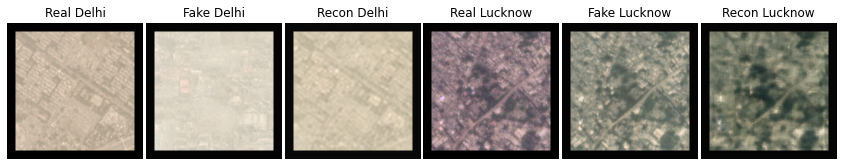

[Epoch 1/50] [Batch 250/2346] [D loss : 0.797538] [G loss : 46.497715 - (adv : 0.597952, cycle : 0.148814, sem : 6.503294, identity : 0.141995)]
90.16277313232422 tensor([232.5400], device='cuda:0')
100.15263366699219 tensor([82.8400], device='cuda:0')
92.1706771850586 tensor([58.7900], device='cuda:0')
105.12371063232422 tensor([208.6500], device='cuda:0')
102.48538970947266 tensor([132.2400], device='cuda:0')
101.1113510131836 tensor([66.6400], device='cuda:0')
108.10887145996094 tensor([353.8800], device='cuda:0')
89.90167999267578 tensor([50.3300], device='cuda:0')
111.65602111816406 tensor([93.1100], device='cuda:0')
111.64366912841797 tensor([147.2800], device='cuda:0')
103.17328643798828 tensor([374.7300], device='cuda:0')
104.96256256103516 tensor([133.8500], device='cuda:0')
104.9579086303711 tensor([50.8600], device='cuda:0')
113.01901245117188 tensor([16.6300], device='cuda:0')
105.79498291015625 tensor([113.4600], device='cuda:0')
97.48100280761719 tensor([203.7900], device

116.9057388305664 tensor([57.1500], device='cuda:0')
123.47663116455078 tensor([206.3200], device='cuda:0')
119.72618865966797 tensor([39.4000], device='cuda:0')
112.28572082519531 tensor([161.5600], device='cuda:0')
113.88125610351562 tensor([68.7400], device='cuda:0')
109.30036163330078 tensor([80.9500], device='cuda:0')
116.76419830322266 tensor([81.7400], device='cuda:0')
118.40780639648438 tensor([131.7700], device='cuda:0')
106.02667999267578 tensor([76.7100], device='cuda:0')
96.95462036132812 tensor([86.4300], device='cuda:0')
106.32878875732422 tensor([61.3400], device='cuda:0')
100.6760025024414 tensor([122.2200], device='cuda:0')
109.337158203125 tensor([83.9300], device='cuda:0')
96.62117004394531 tensor([202.5700], device='cuda:0')
111.06071472167969 tensor([145.2600], device='cuda:0')
96.15652465820312 tensor([142.5000], device='cuda:0')
100.7781982421875 tensor([42.6400], device='cuda:0')
98.18782043457031 tensor([68.0300], device='cuda:0')
120.19245147705078 tensor([152

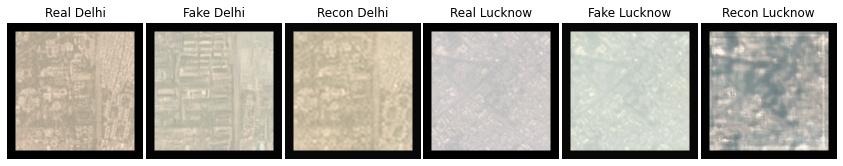

[Epoch 1/50] [Batch 500/2346] [D loss : 0.590144] [G loss : 964.298096 - (adv : 0.851362, cycle : 0.040844, sem : 516.648010, identity : 0.056015)]
108.39954376220703 tensor([260.0800], device='cuda:0')
112.9184341430664 tensor([71.0400], device='cuda:0')
121.60264587402344 tensor([172.2100], device='cuda:0')
109.49930572509766 tensor([66.4900], device='cuda:0')
113.80260467529297 tensor([200.3300], device='cuda:0')
101.55241394042969 tensor([120.0900], device='cuda:0')
107.4503402709961 tensor([125.1500], device='cuda:0')
103.67992401123047 tensor([125.8500], device='cuda:0')
116.4783935546875 tensor([77.2900], device='cuda:0')
110.15282440185547 tensor([220.1000], device='cuda:0')
110.0849609375 tensor([66.6200], device='cuda:0')
121.77725982666016 tensor([81.5900], device='cuda:0')
107.04454040527344 tensor([44.6300], device='cuda:0')
120.3266372680664 tensor([138.0900], device='cuda:0')
112.77388000488281 tensor([121.8300], device='cuda:0')
109.22533416748047 tensor([84.6800], devi

91.3625717163086 tensor([92.8300], device='cuda:0')
96.60791778564453 tensor([209.9300], device='cuda:0')
105.98856353759766 tensor([350.9600], device='cuda:0')
101.17042541503906 tensor([260.8900], device='cuda:0')
103.86119842529297 tensor([64.9400], device='cuda:0')
123.39471435546875 tensor([74.8800], device='cuda:0')
106.8606185913086 tensor([118.6300], device='cuda:0')
117.71263885498047 tensor([60.0100], device='cuda:0')
109.81568145751953 tensor([31.4000], device='cuda:0')
114.6483383178711 tensor([256.], device='cuda:0')
113.9742431640625 tensor([54.3400], device='cuda:0')
94.34471130371094 tensor([91.7900], device='cuda:0')
116.78641510009766 tensor([151.4000], device='cuda:0')
113.70112609863281 tensor([95.], device='cuda:0')
102.92989349365234 tensor([159.0900], device='cuda:0')
116.74929809570312 tensor([56.3400], device='cuda:0')
112.20024108886719 tensor([164.7600], device='cuda:0')
116.41649627685547 tensor([72.6100], device='cuda:0')
121.56188201904297 tensor([52.6800]

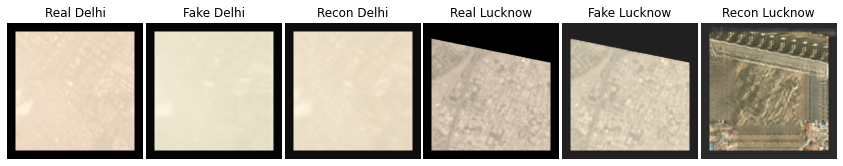

[Epoch 1/50] [Batch 750/2346] [D loss : 0.687534] [G loss : 6.796625 - (adv : 0.847213, cycle : 0.049430, sem : 2.886904, identity : 0.040738)]
100.92448425292969 tensor([123.2500], device='cuda:0')
96.54493713378906 tensor([31.9600], device='cuda:0')
109.1206283569336 tensor([54.1200], device='cuda:0')
93.4095230102539 tensor([71.1400], device='cuda:0')
93.83511352539062 tensor([60.3000], device='cuda:0')
100.0428695678711 tensor([54.3300], device='cuda:0')
85.22602844238281 tensor([22.2600], device='cuda:0')
86.20684814453125 tensor([66.4000], device='cuda:0')
88.56737518310547 tensor([146.3900], device='cuda:0')
100.15882873535156 tensor([136.7300], device='cuda:0')
103.87389373779297 tensor([98.1200], device='cuda:0')
99.84581756591797 tensor([49.4200], device='cuda:0')
92.35694885253906 tensor([40.2500], device='cuda:0')
87.5066909790039 tensor([71.4700], device='cuda:0')
100.71969604492188 tensor([31.2900], device='cuda:0')
93.92863464355469 tensor([69.6200], device='cuda:0')
97.

108.01480102539062 tensor([111.1300], device='cuda:0')
104.52533721923828 tensor([90.4000], device='cuda:0')
115.11021423339844 tensor([137.9500], device='cuda:0')
113.06532287597656 tensor([49.8000], device='cuda:0')
119.6868667602539 tensor([97.7300], device='cuda:0')
115.41307067871094 tensor([50.0400], device='cuda:0')
109.48712921142578 tensor([42.8300], device='cuda:0')
92.32804107666016 tensor([35.1200], device='cuda:0')
100.38444519042969 tensor([63.3800], device='cuda:0')
91.61573791503906 tensor([134.2100], device='cuda:0')
93.03788757324219 tensor([53.4400], device='cuda:0')
95.61675262451172 tensor([76.4800], device='cuda:0')
102.593505859375 tensor([95.3500], device='cuda:0')
107.28491973876953 tensor([21.2200], device='cuda:0')
93.43218231201172 tensor([298.5600], device='cuda:0')
99.3012466430664 tensor([45.3900], device='cuda:0')
111.47252655029297 tensor([106.1600], device='cuda:0')
84.14803314208984 tensor([140.4800], device='cuda:0')
92.43122100830078 tensor([65.5400

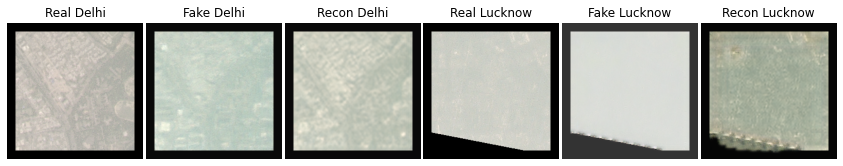

[Epoch 1/50] [Batch 1000/2346] [D loss : 0.694294] [G loss : 7142.211426 - (adv : 0.847842, cycle : 0.040280, sem : 7891.513184, identity : 0.036049)]
109.54719543457031 tensor([187.2800], device='cuda:0')
100.88912200927734 tensor([110.7400], device='cuda:0')
113.040283203125 tensor([112.3500], device='cuda:0')
100.06475067138672 tensor([44.5000], device='cuda:0')
90.26007080078125 tensor([177.2100], device='cuda:0')
97.0256118774414 tensor([115.8400], device='cuda:0')
118.53251647949219 tensor([50.7700], device='cuda:0')
101.55314636230469 tensor([99.2900], device='cuda:0')
100.4243392944336 tensor([146.4000], device='cuda:0')
113.93399047851562 tensor([181.8400], device='cuda:0')
111.21267700195312 tensor([75.9500], device='cuda:0')
123.8258056640625 tensor([66.6200], device='cuda:0')
97.73185729980469 tensor([49.0100], device='cuda:0')
106.11151885986328 tensor([228.3100], device='cuda:0')
104.79769897460938 tensor([100.6200], device='cuda:0')
116.78214263916016 tensor([67.4200], d

103.66500091552734 tensor([227.9200], device='cuda:0')
105.87237548828125 tensor([59.0800], device='cuda:0')
110.17994689941406 tensor([60.7100], device='cuda:0')
108.95667266845703 tensor([128.9900], device='cuda:0')
104.84898376464844 tensor([94.1700], device='cuda:0')
112.61756134033203 tensor([99.5500], device='cuda:0')
90.8802719116211 tensor([62.9600], device='cuda:0')
98.98399353027344 tensor([55.3000], device='cuda:0')
93.32015228271484 tensor([70.5500], device='cuda:0')
89.39659118652344 tensor([79.4800], device='cuda:0')
92.5564193725586 tensor([69.9600], device='cuda:0')
112.28662872314453 tensor([62.3700], device='cuda:0')
94.83949279785156 tensor([268.1700], device='cuda:0')
101.89225006103516 tensor([47.8800], device='cuda:0')
98.00491333007812 tensor([24.8000], device='cuda:0')
96.0819320678711 tensor([105.5300], device='cuda:0')
91.90572357177734 tensor([67.9800], device='cuda:0')
94.73011779785156 tensor([45.4300], device='cuda:0')
91.83455657958984 tensor([81.6200], d

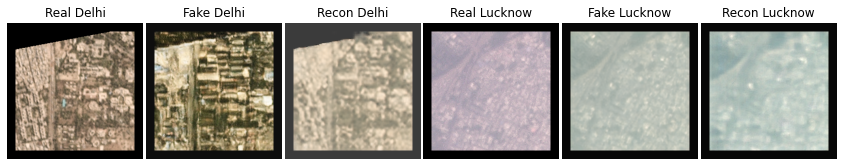

[Epoch 1/50] [Batch 1250/2346] [D loss : 0.669749] [G loss : 5445.139648 - (adv : 0.702241, cycle : 0.016420, sem : 5132.195312, identity : 0.058786)]
109.43054962158203 tensor([175.5000], device='cuda:0')
111.54600524902344 tensor([69.], device='cuda:0')
107.00672149658203 tensor([122.8600], device='cuda:0')
108.07526397705078 tensor([93.1100], device='cuda:0')
112.22438049316406 tensor([25.3400], device='cuda:0')
95.0440902709961 tensor([26.0900], device='cuda:0')
90.86141204833984 tensor([67.8500], device='cuda:0')
90.87296295166016 tensor([57.8300], device='cuda:0')
99.70963287353516 tensor([214.4800], device='cuda:0')
98.50780487060547 tensor([74.1800], device='cuda:0')
103.84709930419922 tensor([260.0800], device='cuda:0')
121.24020385742188 tensor([297.5600], device='cuda:0')
87.34696197509766 tensor([173.2500], device='cuda:0')
111.50350189208984 tensor([48.1700], device='cuda:0')
117.92657470703125 tensor([89.6300], device='cuda:0')
89.04247283935547 tensor([89.4900], device='

109.8379135131836 tensor([128.9500], device='cuda:0')
107.0556411743164 tensor([186.1800], device='cuda:0')
112.05794525146484 tensor([49.3200], device='cuda:0')
108.62899017333984 tensor([75.3100], device='cuda:0')
121.67819213867188 tensor([178.9200], device='cuda:0')
96.08007049560547 tensor([72.1200], device='cuda:0')
107.93965911865234 tensor([87.3500], device='cuda:0')
104.78490447998047 tensor([39.5200], device='cuda:0')
118.8804931640625 tensor([95.7100], device='cuda:0')
120.78760528564453 tensor([32.6700], device='cuda:0')
112.09648895263672 tensor([111.5400], device='cuda:0')
113.55714416503906 tensor([304.9400], device='cuda:0')
106.69497680664062 tensor([426.4800], device='cuda:0')
118.84850311279297 tensor([78.9600], device='cuda:0')
123.05921936035156 tensor([185.9000], device='cuda:0')
98.56121826171875 tensor([13.3400], device='cuda:0')
125.09158325195312 tensor([41.9600], device='cuda:0')
107.44094848632812 tensor([46.3500], device='cuda:0')
116.76290130615234 tensor(

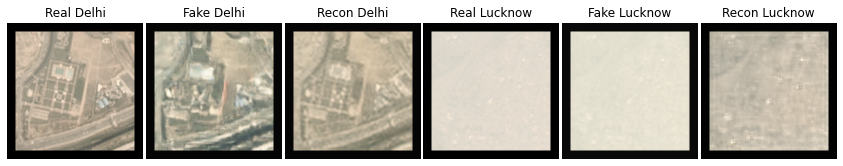

[Epoch 1/50] [Batch 1500/2346] [D loss : 0.606772] [G loss : 187.589691 - (adv : 0.899686, cycle : 0.102171, sem : 348.395081, identity : 0.102681)]
112.56812286376953 tensor([124.0300], device='cuda:0')
116.94351196289062 tensor([97.2500], device='cuda:0')
99.17452239990234 tensor([141.2600], device='cuda:0')
102.23484802246094 tensor([54.5100], device='cuda:0')
81.96807098388672 tensor([19.6100], device='cuda:0')
115.13753509521484 tensor([165.3400], device='cuda:0')
105.20071411132812 tensor([175.4600], device='cuda:0')
99.35163879394531 tensor([51.4800], device='cuda:0')
103.38135528564453 tensor([51.2300], device='cuda:0')
113.9216537475586 tensor([220.1200], device='cuda:0')
102.09370422363281 tensor([210.9800], device='cuda:0')
113.7829360961914 tensor([92.1100], device='cuda:0')
109.43399810791016 tensor([135.3600], device='cuda:0')
112.18853759765625 tensor([15.4000], device='cuda:0')
112.4267349243164 tensor([176.6100], device='cuda:0')
117.38047790527344 tensor([109.1500], d

114.58392333984375 tensor([267.1700], device='cuda:0')
117.58094787597656 tensor([17.0400], device='cuda:0')
103.88883209228516 tensor([44.2100], device='cuda:0')
98.07965850830078 tensor([21.5200], device='cuda:0')
93.35808563232422 tensor([67.6700], device='cuda:0')
107.15735626220703 tensor([66.8500], device='cuda:0')
103.37776947021484 tensor([76.2900], device='cuda:0')
136.40245056152344 tensor([195.5900], device='cuda:0')
123.70375061035156 tensor([29.5400], device='cuda:0')
107.54397583007812 tensor([134.4700], device='cuda:0')
105.3452377319336 tensor([57.8700], device='cuda:0')
105.83946228027344 tensor([105.9900], device='cuda:0')
114.57145690917969 tensor([72.2900], device='cuda:0')
123.70134735107422 tensor([288.2100], device='cuda:0')
103.9819564819336 tensor([78.2200], device='cuda:0')
101.47277069091797 tensor([31.4800], device='cuda:0')
105.43282318115234 tensor([49.3800], device='cuda:0')
117.95804595947266 tensor([74.4000], device='cuda:0')
102.36126708984375 tensor([

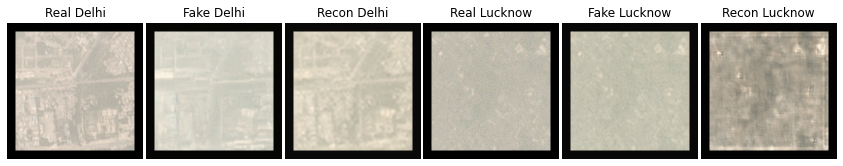

[Epoch 1/50] [Batch 1750/2346] [D loss : 0.636320] [G loss : 386.579620 - (adv : 0.796063, cycle : 0.026845, sem : 381.213165, identity : 0.039460)]
107.86652374267578 tensor([134.0700], device='cuda:0')
109.45667266845703 tensor([40.1500], device='cuda:0')
105.5984878540039 tensor([86.9600], device='cuda:0')
119.60889434814453 tensor([66.4300], device='cuda:0')
114.28211212158203 tensor([410.8900], device='cuda:0')
104.2314682006836 tensor([120.8000], device='cuda:0')
88.80644989013672 tensor([32.6900], device='cuda:0')
108.300048828125 tensor([29.4400], device='cuda:0')
119.81724548339844 tensor([37.8700], device='cuda:0')
114.99056243896484 tensor([166.8300], device='cuda:0')
118.92356872558594 tensor([95.6400], device='cuda:0')
110.60354614257812 tensor([89.0400], device='cuda:0')
110.19400787353516 tensor([61.3700], device='cuda:0')
87.1708984375 tensor([97.7300], device='cuda:0')
84.69769287109375 tensor([62.6400], device='cuda:0')
100.03636169433594 tensor([119.1900], device='cu

KeyboardInterrupt: 

In [19]:
history = {'epoch':[],'G_loss':[],'adv_loss': [],'cyc_loss': [], 'idt_loss': [], 'D_loss':[], 'batch':[]}
best_D_loss = 1e6
best_G_loss = 1e6
best_sem_loss = 1e7

for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(tqdm(dataloader)):
        
        # Set model input
        real_A = batch['D'].type(Tensor)
        real_B = batch['L'].type(Tensor)
        lbl_A = batch['D pm'].type(Tensor)
        
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)

        
        pm_from_real_source = C_A(real_A).squeeze(1)
        pm_from_real_target = C_A(real_B).squeeze(1)
        
        pm_from_fake_target = C_A(fake_B.detach()).squeeze(1)
        pm_from_fake_source = C_A(fake_A.detach()).squeeze(1)
        
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        
        # Adversarial ground truths
        valid = Tensor(np.ones((real_A.size(0), *D_A.output_shape))) 
        fake = Tensor(np.zeros((real_A.size(0), *D_A.output_shape)))
        

        dft_source_lbl = torch.ones(real_A.size()[0]).long().to(device)
        dft_targ_lbl = torch.zeros(real_A.size()[0]).long().to(device)

# -----------------
# Train Generators ;;No backwards run in phase 3;;
# -----------------
        G_AB.train() # train mode
        G_BA.train() # train mode
        
        optimizer_G.zero_grad() # Integrated optimizer(G_AB, G_BA)
        
        # Identity Loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A) # If you put A into a generator that creates A with B,
        loss_id_B = criterion_identity(G_AB(real_B), real_B) # then of course A must come out as it is.
                                                             # Taking this into consideration, add an identity loss that simply compares 'A and A' (or 'B and B').
        loss_identity = (loss_id_A + loss_id_B)/2
        
        # GAN Loss
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) # tricking the 'fake-B' into 'real-B'
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid) # tricking the 'fake-A' into 'real-A'
        
        loss_GAN = (loss_GAN_AB + loss_GAN_BA)/2
        
        # Cycle Loss
        loss_cycle_A = criterion_cycle(recov_A, real_A) # Reduces the difference between the restored image and the real image
        
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        
        loss_cycle = (loss_cycle_A + loss_cycle_B)/2
        

# ------> Total Loss
        loss_G = loss_GAN + (15.0*loss_cycle) + (5.0*loss_identity) # multiply suggested weight(default cycle loss weight : 10, default identity loss weight : 5)
        
        # Semantic Loss
#         print(f'pm from real source: {pm_from_real_source.item()}\npm from fake target: {pm_from_fake_target.item()}\n\npm from real target: {pm_from_real_target.item()}\npm from fake source: {pm_from_fake_source.item()}\n')

        loss_sem_AB = criterion_PM(pm_from_fake_target, lbl_A)
        loss_sem_BA = criterion_PM(pm_from_fake_source, pm_from_real_target)
        
        loss_G += loss_sem_AB + loss_sem_BA
        
#         loss_G.backward()
        optimizer_G.step()
        
# -------------------------------------------
# Train Discriminator A and Discriminator B ;;No backwards run in phase 3;;
# -------------------------------------------
        optimizer_D.zero_grad()
        
        loss_real = criterion_GAN(D_A(real_A), valid) # train to discriminate real images as real
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake) # train to discriminate fake images as fake
        loss_D_A = (loss_real + loss_fake)/2
#         loss_D_A.backward()

        loss_real = criterion_GAN(D_B(real_B), valid) # train to discriminate real images as real
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake) # train to discriminate fake images as fake
        loss_D_B = (loss_real + loss_fake)/2
#         loss_D_B.backward()
        
# ------> Total Loss
        loss_D = (loss_D_A + loss_D_B)/2
        optimizer_D.step()
        
# -----------------
# Train C_A  ;;No backwards run in phase 3;;
# -----------------
        optimizer_C_A.zero_grad()
        # forward only real source image through semantic classifier
        loss_sem = criterion_PM(pm_from_real_source, lbl_A)
#         loss_sem.backward()
        
        optimizer_C_A.step()

# ------------------------
# Train Discriminator Dft
# ------------------------
        set_requires_grad([C_B], False)
        set_requires_grad([D_ft], True)
        optimizer_D_ft.zero_grad()
        
        # Source
        pred_source = D_ft(C_A(fake_B.detach())).squeeze(1)
        loss_D_ft_s = criterion_GAN(pred_source, dft_source_lbl.float())
        
        # Target
        pred_target = D_ft(C_B(real_B)).squeeze(1)
#         print(pred_source.item(), pred_target.item())
        loss_D_ft_t = criterion_GAN(pred_target, dft_targ_lbl.float())
#         print(loss_D_ft_s.item(), loss_D_ft_t.item())
#         print()
        # Combined loss
        loss_D_ft_adv = (loss_D_ft_s + loss_D_ft_t) * 0.5
        
        loss_D_ft_adv.backward()
        optimizer_D_ft.step()
        
        #feature discriminator accuracy
        _, score_acc_S = prediction(pred_source, dft_source_lbl)
        _, score_acc_T = prediction(pred_target, dft_targ_lbl)
        score_acc_D_ft = (score_acc_S + score_acc_T)/2
        
#-----------------       
# Train C_B
#-----------------
        set_requires_grad([D_ft], False)
        set_requires_grad([C_B], True)
        optimizer_C_B.zero_grad()
        pred_target = C_B(fake_B.detach()).squeeze(1) # C_B(G_A(A))
        loss_C_B_task = criterion_PM(pred_target, lbl_A)
        
        print(pred_target.item(), lbl_A)
        # only update net if discriminator is strong
        
        if score_acc_D_ft > 0.6:
            print(f'Feature Discriminator improved! Acc: {score_acc_D_ft}')
            pred_target = D_ft(C_B(real_B)).squeeze(1) # D_ft(C_B(B))
            loss_C_B_adv = criterion_GAN(pred_target, dft_targ_lbl.float())
        else:
            loss_C_B_adv = 0
            
        loss_C_B = loss_C_B_task + loss_C_B_adv
        loss_C_B.backward()  
        optimizer_C_B.step()
        
# -----------------
# Model Saving
# -----------------    
#         if loss_D <= best_D_loss:
#             best_D_loss = loss_D
#             torch.save({'D_B': D_B.state_dict(), 'D_A': D_A.state_dict()}, '/datacommons/carlsonlab/srs108/cycle/saved_models/best_D.pt')
            
#         if loss_G <= best_G_loss:
#             best_G_loss = loss_G
#             torch.save({ 'G_AB': G_AB.state_dict(),'G_BA': G_BA.state_dict()}, '/datacommons/carlsonlab/srs108/cycle/saved_models/best_G.pt')
            
#         if loss_sem <= best_sem_loss:
#             best_sem_loss = loss_sem
#             torch.save({'C_A': C_A.state_dict()}, '/datacommons/carlsonlab/srs108/cycle/saved_models/sem_model.pt')
        
        
# -----------------
# Show Progress
# -----------------
        if (i+1) % 250 == 0:
            with torch.no_grad():
                sample_images('Delhi', 'Lucknow',dataloader, epoch, i, show = True, save = False)

                sample_images('Delhi', 'Lucknow',val_dataloader, epoch, i, show = False, save = False)
#                 print(f'pm from real source: {pm_from_real_source.item()}\npm from fake target: {pm_from_fake_target.item()}\n\npm from real target: {pm_from_real_target.item()}\npm from fake source: {pm_from_fake_source.item()}\n')

                print('[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, sem : %f, identity : %f)]'
                        %(epoch+1,n_epochs,       # [Epoch -]
                          i+1,len(dataloader),   # [Batch -]
                          loss_D.item(),       # [D loss -]
                          loss_G.item(),       # [G loss -]
                          loss_GAN.item(),     # [adv -]
                          loss_cycle.item(),   # [cycle -]
                          loss_sem.item(),     # [sem -]
                          loss_identity.item(),# [identity -]
                     ))
            
            history['G_loss'].append(loss_G.item())
            history['D_loss'].append(loss_D.item())
            history['batch'].append(i+1)
            history['epoch'].append(epoch+1)
            history['adv_loss'].append(loss_GAN.item())
            history['cyc_loss'].append(loss_cycle.item())
            history['idt_loss'].append(loss_identity.item())
            


In [ ]:
df = pd.DataFrame(history)
df.to_csv('history.csv', index=False)

In [ ]:
def prediction(out, target=None, onehot=True):
    if target is None :
        _, label = torch.max(out.data, 1)
        return label
    else:
        if onehot:
            _, label = torch.max(out.data, 1)
        else: #if output is a one channel, set a label where threshold is 0.5
            label = torch.where(out.data>torch.FloatTensor([0.5]), torch.ones(out.size()[0]).long(), torch.zeros(out.size()[0]).long())
        acc = (label == target).sum().item() / target.size()[0]
        return label, acc